# MOEA ANALYSIS 

This notebook implements a Multi-Objective Evolutionary Algorithm (MOEA) using the EMA Workbench to evaluate a set of policies under different deeply uncertain scenarios derived from the PRIM analysis. The primary goal is to discover robust policy trade-offs across the multiple KPI's, the in our case five scenarios from problem formulation 2: 
Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# EMA Workbench imports
import ema_workbench

from ema_workbench import (Model, Constraint, RealParameter, ScalarOutcome, MultiprocessingEvaluator,ema_logging, Constant, Scenario, HypervolumeMetric,
                           GenerationalDistanceMetric, EpsilonIndicatorMetric,InvertedGenerationalDistanceMetric, SpacingMetric)
from ema_workbench.em_framework.optimization import (
    EpsilonProgress, to_problem, ArchiveLogger, epsilon_nondominated)
from ema_workbench.analysis import parcoords
# Problem formulation import
from problem_formulation import get_model_for_problem_formulation 
from ema_workbench.em_framework.optimization import (HypervolumeMetric,GenerationalDistanceMetric,EpsilonIndicatorMetric,InvertedGenerationalDistanceMetric,
                                                     SpacingMetric)

c:\Users\quint\Documents\Ralph\.venv\Lib\site-packages\ema_workbench\em_framework\__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


**Constants:**
In the following cell the epsilon values, nfe, outcomes of interest and scenario and archive folder can be set.

epsilon_values: Precision thresholds used by ε-NSGA-II to determine solution dominance.
nfe: Number of function evaluations, metric indicating the computational effort.
outcomes_of_interest: Performance metrics considered during optimization.
scenario_file: Results from the PRIM under which the policies will be optimized
output_dir: folder where the results will be saved

In [ ]:
# Constants
# Directory where output files will be saved
output_dir = 'archives'
# Path to the scenario data file (likely contains input scenarios for the model or simulation)
scenario_file = './data/Selected_Scenarios2.csv'
# Epsilon values used for multi-objective optimization (e.g., ε-NSGA-II).
epsilon_values = [[1e6, 1e6, 1e6, 1e6, 10]]
# Number of function evaluations allowed in the optimization process (e.g., max iterations)
nfe = 40000
# List of performance metrics or objectives that the model will track or optimize.
outcomes_of_interest = [
    'Expected Annual Damage',       # Economic loss due to flooding averaged annually
    'Dike Investment Costs',        # Cost of constructing or upgrading dikes
    # Cost of Room for the River (RfR) measures (e.g., widening floodplains)
    'RfR Investment Costs',
    'Evacuation Costs',             # Cost associated with evacuation plans and execution
    'Expected Number of Deaths'     # Estimated fatalities due to flooding
]

# Optimization Function

This function runs the multi-objective evolutionary algorithm (ε-NSGA-II) optimization for each scenario and multiple random seeds to ensure robust results. It uses the EMA Workbench's MultiprocessingEvaluator for parallel execution.

Steps:
- Creates output directory if missing.
- Loops over all scenarios and seeds.
- Sets up convergence metrics to track optimization progress.
- Runs optimization with a fixed number of function evaluations (nfe).
- Saves results and convergence data to CSV files.
- Collects all results and convergence info for further analysis.

Inputs:
- epsilon: Precision thresholds controlling solution granularity.
- scenarios: List of uncertain future scenarios derived from the PRIM.
- model: The dike model.
- seeds: Number of repetitions to reduce stochastic effects (default 3).

Outputs:
- Lists of optimization results and convergence histories for each run.

In [ ]:
def run_optimization(epsilon, scenarios, model, seeds=3):
    # Store results and convergence data
    results = []
    convergences = []

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Use parallel evaluator
    with MultiprocessingEvaluator(model) as evaluator:
        for scenario in scenarios:
            for seed in range(seeds):
                # Set up convergence tracking
                convergence_metrics = [
                    ArchiveLogger(
                        output_dir,
                        [lever.name for lever in model.levers],
                        [outcome.name for outcome in model.outcomes],
                        base_filename="optimization.tar.gz"
                    ),
                    EpsilonProgress()
                ]

                # Run the optimization
                result, convergence = evaluator.optimize(
                    nfe=nfe,
                    searchover="levers",
                    epsilons=epsilon,
                    constraints=None,
                    convergence=convergence_metrics,
                    reference=scenario
                )

                # Define filenames for output
                result_file = os.path.join(
                    output_dir, f"result__scen{scenario.name}__seed{seed}.csv")
                convergence_file = os.path.join(
                    output_dir, f"convergence__scen{scenario.name}__seed{seed}.csv")

                # Save results
                result.to_csv(result_file, index=False)
                pd.DataFrame(convergence).to_csv(convergence_file, index=False)

                # Append to overall results
                results.append(result)
                convergences.append(convergence)

    return results, convergences

# Utility Functions for Data Loading and Visualization

This set of helper functions supports the optimization workflow by managing results files, loading scenarios, and visualizing outcomes:

- load_results_from_files(directory)
Scans the given directory for all CSV files prefixed with "result__" and combines them into one pandas DataFrame. This makes it easy to aggregate results from multiple optimization runs for analysis.

- ensure_directory_exists(directory)
Checks if a directory exists and creates it if missing. This prevents errors when saving results or plots.

- load_scenarios(filepath)
Loads scenario definitions from a CSV file where each row represents a scenario with uncertain parameters. Converts each row into a Scenario object for use as a reference in optimization.

- plot_parallel_coordinates(results, eps)
Generates and saves a parallel coordinates plot for key outcome metrics, enabling visual inspection of trade-offs across objectives for the specified epsilon value. This helps to understand the diversity and quality of the Pareto front solutions

In [4]:
def load_results_from_files(directory):
    """
    Loads all optimization result CSVs from a directory into a single DataFrame.
    """
    results = []
    for filename in os.listdir(directory):
        if filename.startswith("result__") and filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            results.append(df)
    return pd.concat(results, ignore_index=True)


def ensure_directory_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [ ]:
def load_scenarios(filepath):
    # Read scenario data from CSV
    df = pd.read_csv(filepath)
    scenarios = []

    # Convert each row into a Scenario object
    for _, row in df.iterrows():
        name = row['scenario']  # Row with the scenario identifier
        # All other columns as parameters
        parameters = row.drop(labels='scenario').to_dict()
        scenarios.append(Scenario(name, **parameters))

    return scenarios

In [ ]:
def plot_parallel_coordinates(results, eps):
    # Extract only the outcome columns from the results
    outcomes = results[outcomes_of_interest]
    # Get axis limits based on the outcome data
    limits = parcoords.get_limits(outcomes)
    # Set up parallel coordinates axes
    axes = parcoords.ParallelAxes(limits)
    # Plot the outcome data
    axes.plot(outcomes)
    # Add title and save the plot
    plt.title(f'Parallel Coordinates Plot for Epsilon {eps}')
    plt.savefig(f'parallel_coordinates_eps_{eps}.png')
    plt.show()

**Main Execution Flow**

In the following cell the optimization execution is set up by using the previously defined functions. It sets up logging, ensures the output directory exists, loads the model and scenarios, then runs the optimization for each epsilon value, loads the saved results, and visualizes the trade-offs with parallel coordinates plots.

In [7]:
ema_logging.log_to_stderr(ema_logging.INFO)

ensure_directory_exists(output_dir)

model, steps = get_model_for_problem_formulation(2)
scenarios = load_scenarios(scenario_file)

for eps in epsilon_values:
    results, convergences = run_optimization(eps, scenarios, model)

[MainProcess/INFO] pool started with 24 workers
40381it [15:21, 43.82it/s]                                                     
[MainProcess/INFO] optimization completed, found 197 solutions
40375it [16:59, 39.59it/s]                                                     
[MainProcess/INFO] optimization completed, found 183 solutions
40086it [16:24, 40.73it/s]                                                     
[MainProcess/INFO] optimization completed, found 191 solutions
40129it [16:38, 40.18it/s]                                                     
[MainProcess/INFO] optimization completed, found 124 solutions
40107it [16:39, 40.13it/s]                                                     
[MainProcess/INFO] optimization completed, found 126 solutions
40266it [17:00, 39.45it/s]                                                     
[MainProcess/INFO] optimization completed, found 120 solutions
40315it [16:49, 39.92it/s]                                                     
[MainProcess/I

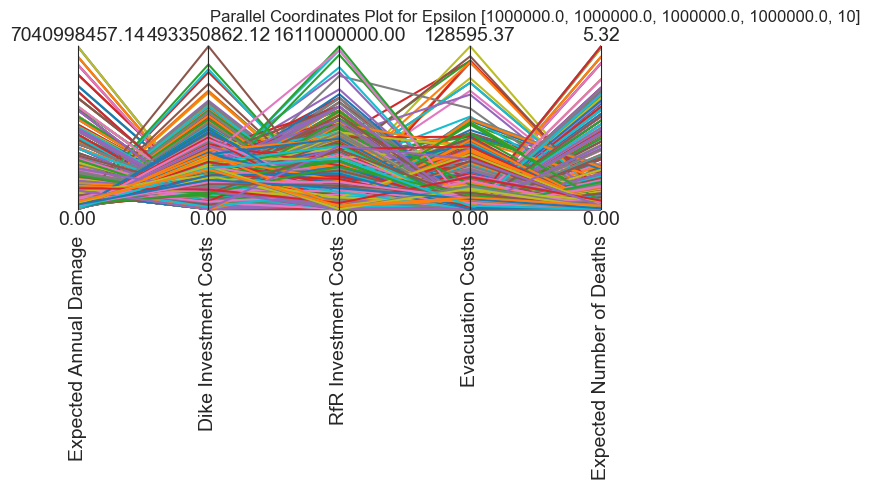

In [8]:
# Load results from files and plot parallel coordinates, this is seperate from the optimization loop to allow for the plotting of different results 
# Without the need to re-run the optimization
for eps in epsilon_values:
    optimization_results_2 = load_results_from_files(output_dir)
    plot_parallel_coordinates(optimization_results_2, eps)    

**Amount of found policies**

In [9]:
print(len(optimization_results_2))

2672


# Filtering Pareto-Optimal Policies

Because the optimization was ran for 3 seeds it is possible that not all policies are Pareto-optimal.
This section filters the Pareto-optimal (non-dominated) policies from the optimization results, assuming all objectives are minimized. A vectorized function (get_non_dominated_mask) is used to identify policies that are not outperformed across all objectives. The filtered set, representing the trade-off frontier, is saved for further analysis.

In [10]:
def get_non_dominated_mask(objectives: np.ndarray) -> np.ndarray:
    """
    Identify non-dominated points using an explicit, correct vectorized loop.

    Parameters:
    objectives (np.ndarray): A 2D array of shape (n_points, n_objectives)

    Returns:
    np.ndarray: A boolean array indicating non-dominated solutions.
    """
    n_points = objectives.shape[0]
    is_efficient = np.ones(n_points, dtype=bool)

    for i in range(n_points):
        if not is_efficient[i]:
            continue
        dominates = np.all(objectives <= objectives[i], axis=1) & np.any(
            objectives < objectives[i], axis=1)
        is_efficient[dominates] = False
        is_efficient[i] = True  # Ensure self is not cleared

    return is_efficient

In [28]:
objective_values = optimization_results_2[outcomes_of_interest].values
mask = get_non_dominated_mask(objective_values)
filtered = optimization_results_2[mask]
print(len(filtered)) 

1324


In [12]:
filtered.to_csv("Pareto_Optimal_Results_2.csv", index=False)
print("Saved Pareto-optimal policies to pareto_optimal_results.csv")

Saved Pareto-optimal policies to pareto_optimal_results.csv


Due to the computational demands of the robustness analysis, we chose to pre-filter the policy options to include only those with an expected casualty count below 0.01. This stringent threshold allows us to focus the analysis on policies that offer an extremely high level of life safety, aligning with a precautionary principle and prioritizing human life in policy evaluation.

In [39]:
# Filter the DataFrame to include only rows where deaths <= 0.01
filtered_deaths = filtered[(filtered['Expected Number of Deaths'] >= 0) &
                           (filtered['Expected Number of Deaths'] <= 0.01)]

# Print how many rows meet this condition
print(len(filtered_deaths))

# Save the resulting DataFrame
filtered_deaths.to_csv("Policies_filtered_on_deaths.csv", index=False)

261


# Convergence Metrics

In the following cells we attempted to set up and visualize the convergence metrics. However, we were not able to overcome this specific EMA error: 

*EMAError: Parameter names ['0_RfR 0', '0_RfR 1', ..., 'A.5_DikeIncrease 2'] not found in archive*

This error indicates that the parameter names expected by the convergence metric functions do not match those stored in the archive. It likely arises from discrepancies in naming conventions, especially when parameters contain spaces, dots, or digits, which the EMA framework sanitizes internally but the archive files may not reflect.

We tried to resolve this issue by sanitizing parameter names, replacing spaces and dots with underscores and prefixing digits to align the archive columns with EMA’s expectations. However, the error kept coming back, preventing us from fully computing and plotting convergence metrics. To make sure our function does converge without visualizing it, we set the number of function evaluations (nfe) to an extra high number (40,000 instead of the initial 20,000).

Overall, the convergence code is designed to compute several key metrics, such as hypervolume, generational distance, epsilon indicator, inverted generational distance, and spacing. These metrics quantify how well the optimization is converging towards a well-distributed and complete Pareto front as the nfe increases.

The included code uses EMA Workbench’s metric classes to calculate these values for stored archives at different stages of the optimization. The results can then be plotted to visualize the progression of convergence over time.

In [21]:
from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem


def calculate_metrics(archives, reference_set):
    problem = to_problem(model, searchover="levers")

    hv = HypervolumeMetric(reference_set, problem)
    gd = GenerationalDistanceMetric(reference_set, problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set, problem)
    ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
    sm = SpacingMetric(problem)

    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    return metrics


def plot_metrics(metrics, convergence):
    sns.set_style("white")
    fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

    ax1, ax2, ax3, ax4, ax5, ax6 = axes

    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel(r'$\epsilon$ progress')

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

    ax6.set_xlabel("nfe")

    sns.despine(fig)

In [22]:
def sanitize(name):
    name = name.replace(" ", "_").replace(".", "_")
    if name[0].isdigit():
        name = f"p_{name}"
    return name


def compute_metrics_from_archive(archive_path, csv_file, model):
    # Load archive
    archive_df = load_archive_csv(archive_path, csv_file)

    # Extract the problem (includes real parameter and outcome names)
    problem = to_problem(model, searchover="levers")

    # Create mapping from sanitized column names -> original names
    rename_map = {}
    for name in list(problem.parameter_names) + list(problem.outcome_names):
        sanitized = sanitize(name)
        rename_map[sanitized] = name

    # Rename sanitized DataFrame columns back to expected original names
    archive_df.columns = [rename_map.get(col, col)
                          for col in archive_df.columns]

    # Final check: are all needed columns present?
    expected = list(problem.parameter_names) + list(problem.outcome_names)
    missing = [col for col in expected if col not in archive_df.columns]
    if missing:
        raise ValueError(
            f"Missing expected columns in cleaned archive: {missing}")

    # Compute metrics
    hv = HypervolumeMetric(reference_set=archive_df, problem=problem)
    gd = GenerationalDistanceMetric(
        reference_set=archive_df, problem=problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set=archive_df, problem=problem)

    return {"HV": hv(), "GD": gd(), "EI": ei()}

In [25]:
import tarfile
import os


def load_archive_csv(archive_path, csv_file):
    import pandas as pd

    if not os.path.exists(csv_file):
        with tarfile.open(archive_path, "r:gz") as tar:
            try:
                tar.extract(csv_file)
            except KeyError:
                raise FileNotFoundError(f"{csv_file} not found in archive.")

    return pd.read_csv(csv_file)

In [26]:
 # your EMA model
metrics = compute_metrics_from_archive(
    archive_path="./archives/optimization.tar.gz",
    csv_file="tmp/100.csv",
    model=model
)

print(metrics)

EMAError: Parameter names ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'] not found in archive